In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from scipy import stats
from scipy.stats import rankdata, norm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import time, os, warnings, random, string, re, gc, sys

import category_encoders as ce

import lightgbm as lgb
import catboost as cb



if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    

def set_seed(seed=4242):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

plt.style.use('fivethirtyeight')

# Encoding Method : Cats on a Hot Tin Roof
# Quick EDAもできる。
# https://www.kaggle.com/arashnic/cats-on-a-hot-tin-roof-cats-encoding-method/comments

# 1~5までは理解　catの仕組みは良くわかってない。classとかの理解も必要。

# ざっくりEncodingについて説明。
https://ishitonton.hatenablog.com/entry/2019/02/24/184253

## Quick EDA

In [74]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
del train['id']
del test['id']

# サイズの確認

In [4]:
#サイズの確認
train.shape,test.shape

((300000, 25), (200000, 24))

# 初手,infoでデータ型、Index数、nullの個数、カラム一覧、memory usageを把握。

In [5]:
#初手,infoでデータ型、Index数、nullの個数、カラム一覧、memory usageを把握。
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

# カテゴリ変数と量的変数にわけてカラムをlist化

In [6]:
cats = [i for i in train.columns if train[i].dtype == 'object']
nums = [i for i in train.columns if not train[i].dtype == 'object']

# targetを削除

In [7]:
#targetを削除
nums.pop(-1)

'target'

In [8]:
#削除後
nums

['cont0',
 'cont1',
 'cont2',
 'cont3',
 'cont4',
 'cont5',
 'cont6',
 'cont7',
 'cont8',
 'cont9',
 'cont10',
 'cont11',
 'cont12',
 'cont13']

# targetのヒストグラムを正規分布と比較。

<AxesSubplot:xlabel='target', ylabel='Density'>

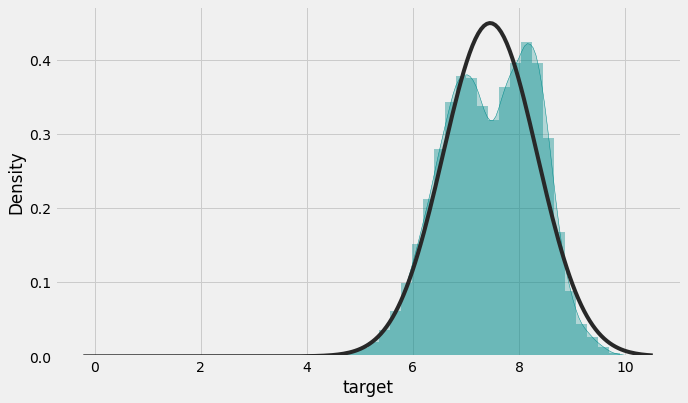

In [9]:
#trainとtestのcopy
tr_orig = train.copy()
ts_orig = test.copy()
#targetのヒストグラムを正規分布と比較。
plt.figure(figsize=(10, 6))
sns.distplot(train.target,bins=50,  fit=norm,kde=True,kde_kws={"shade": True}, norm_hist=True,  color='darkcyan')

# trainとtestの分布を重ねて確認。 結構重い。

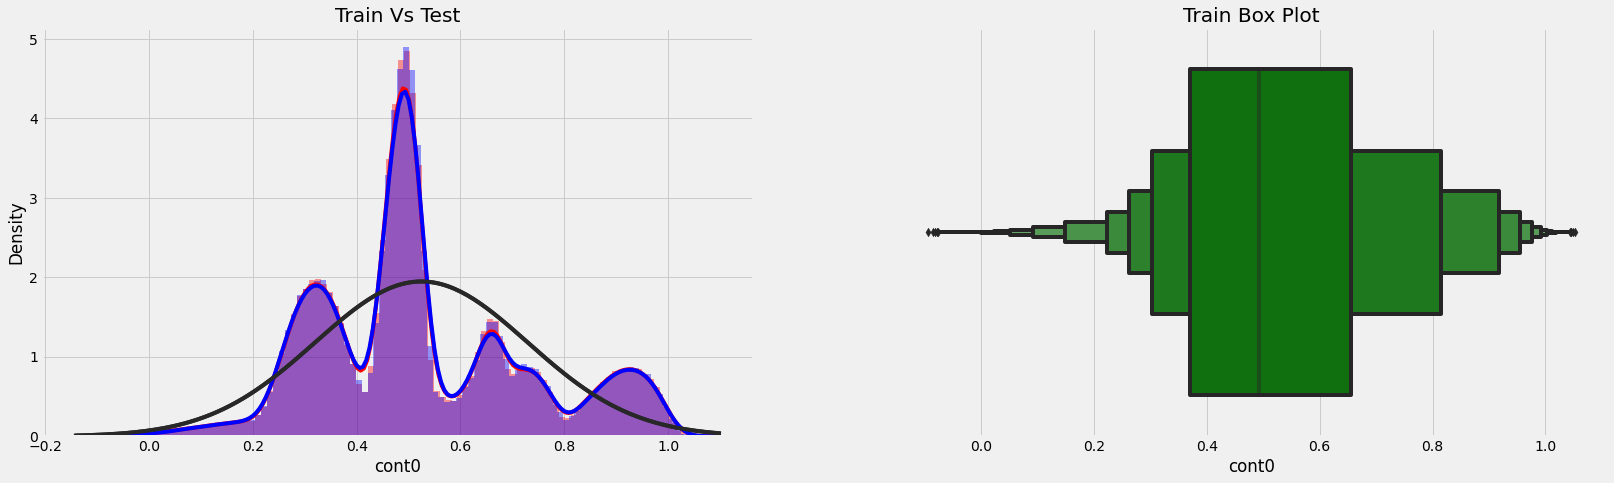

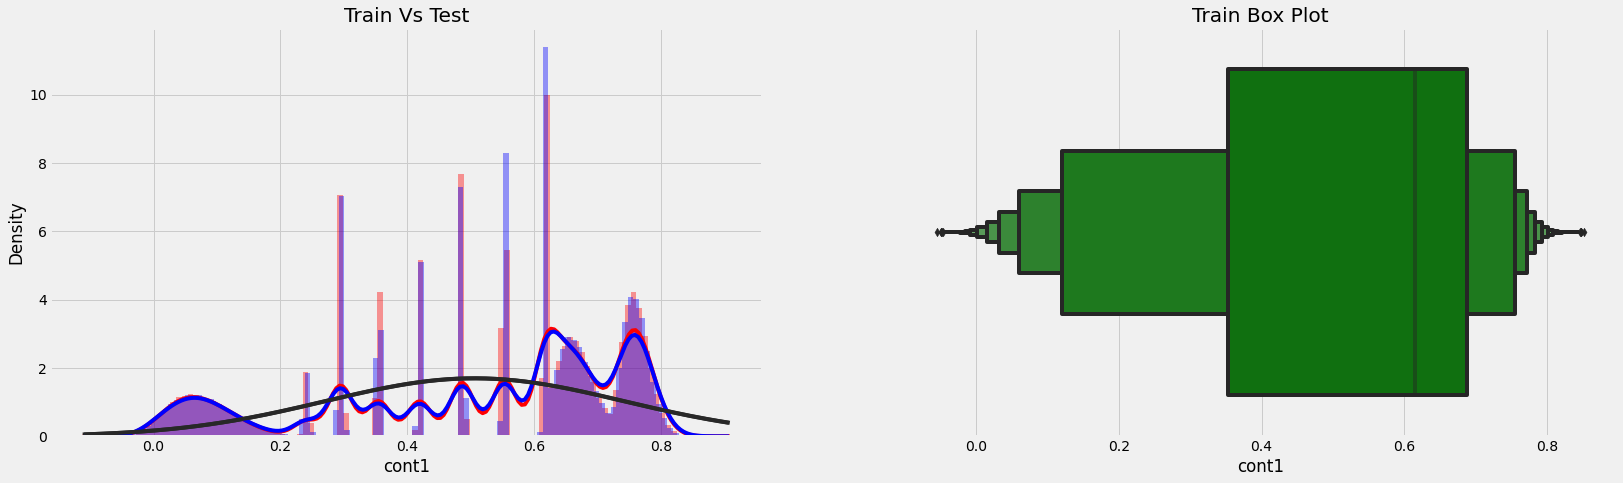

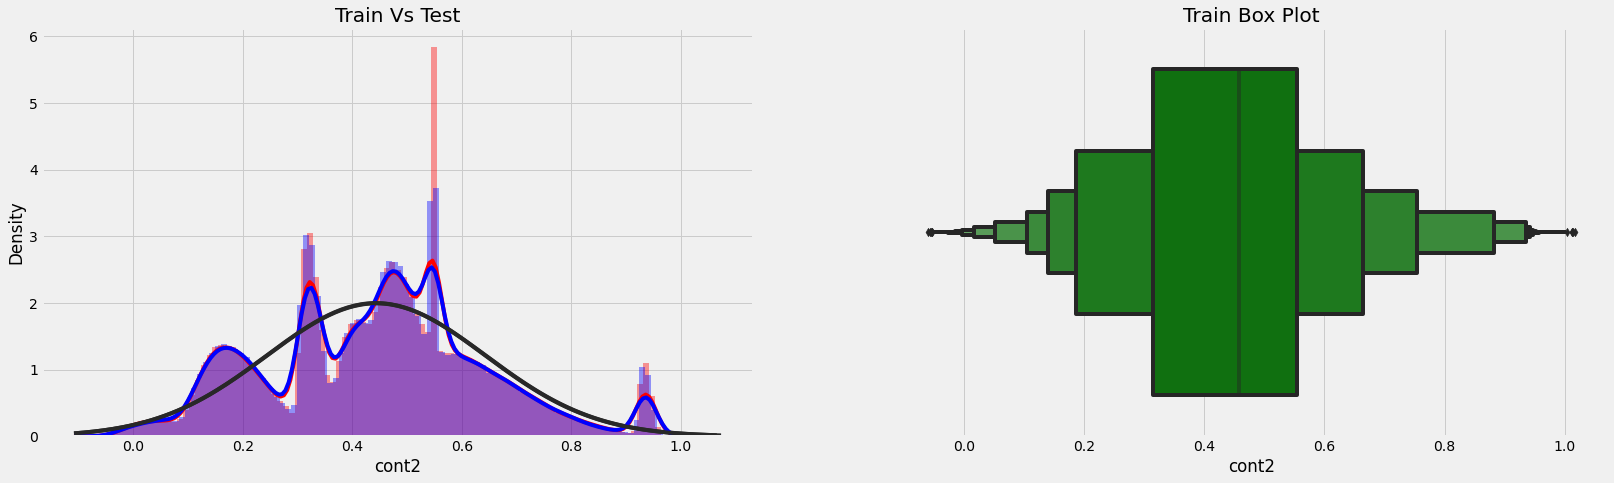

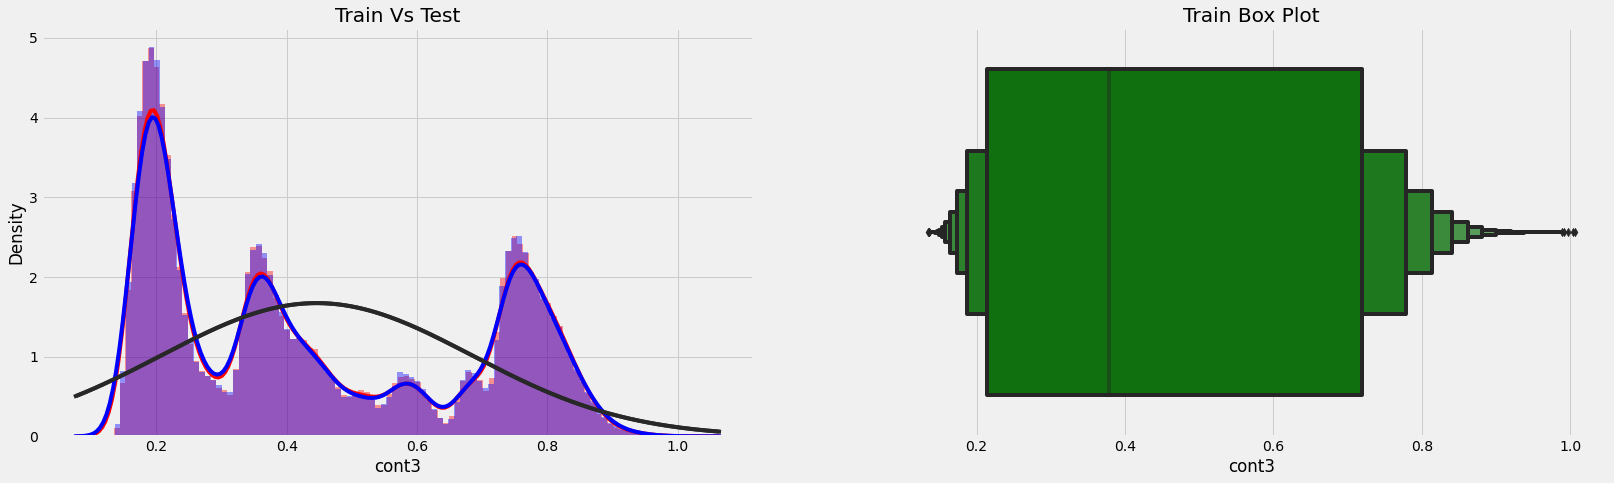

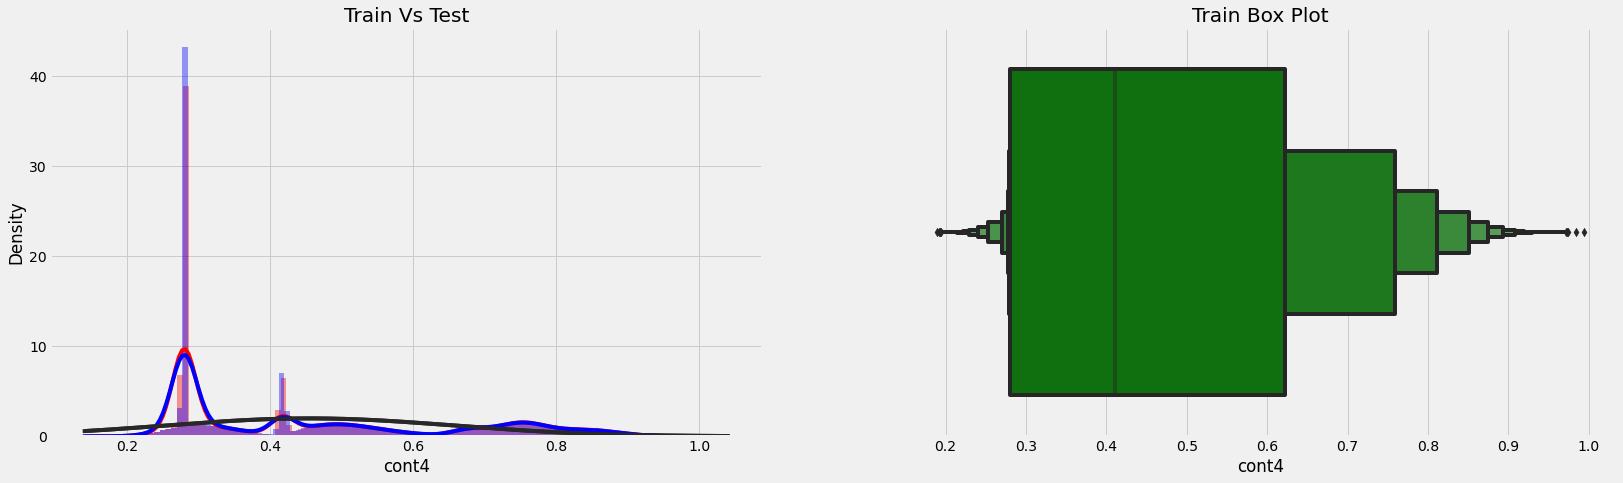

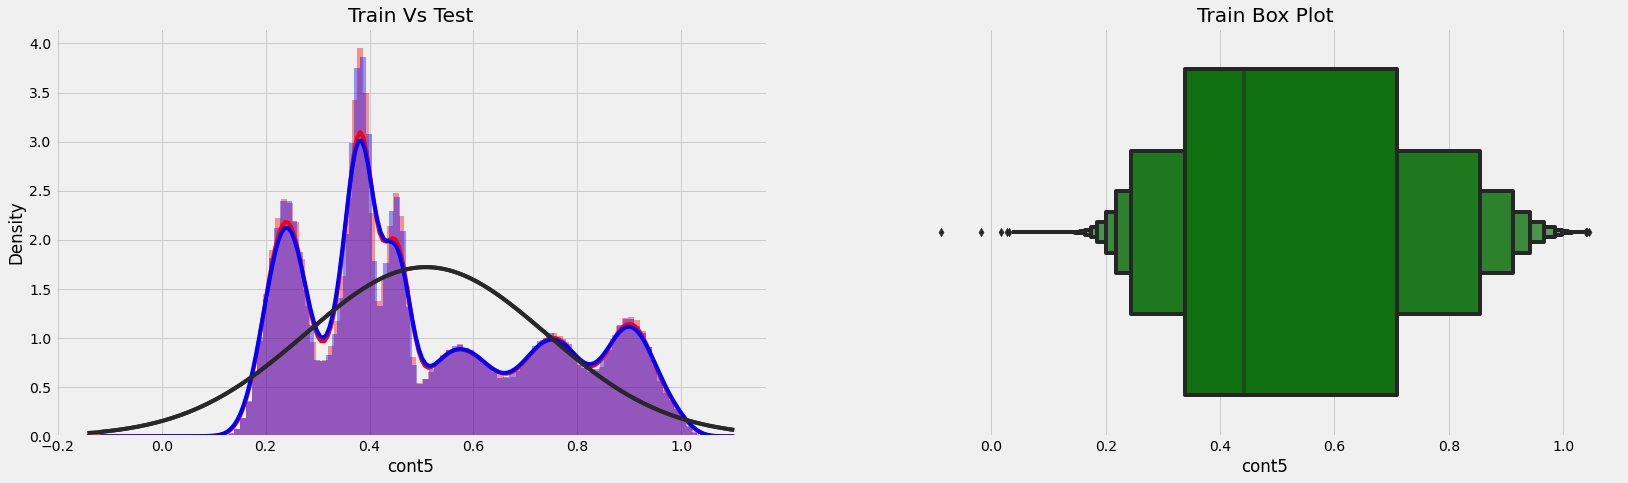

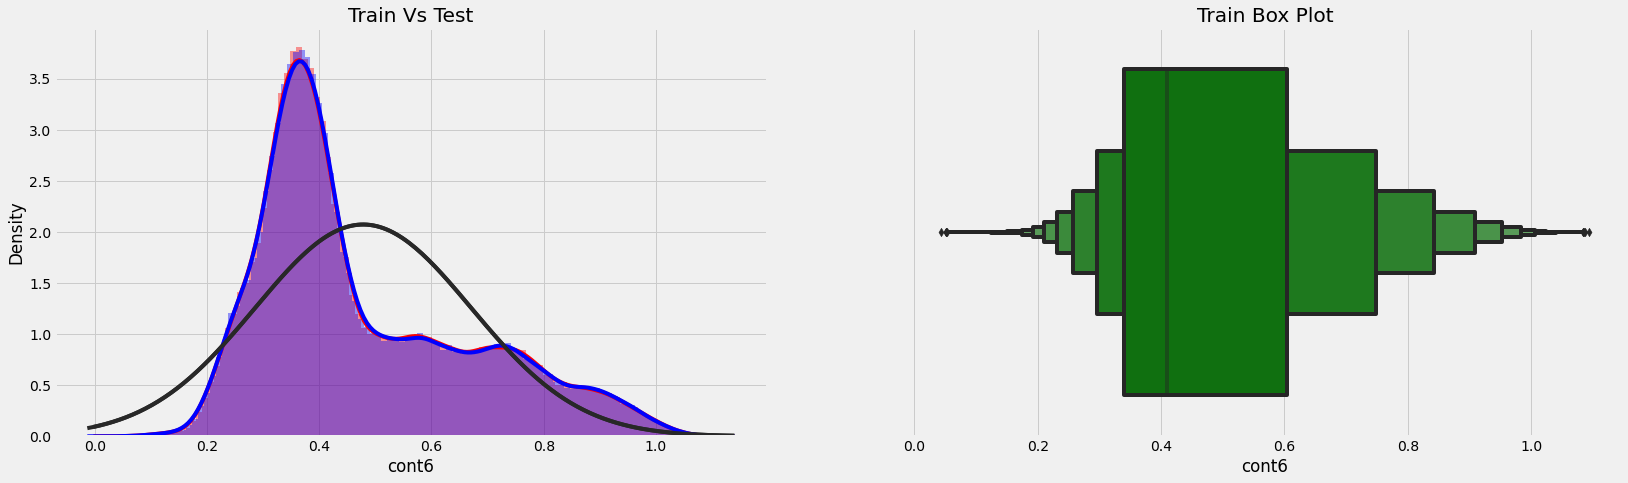

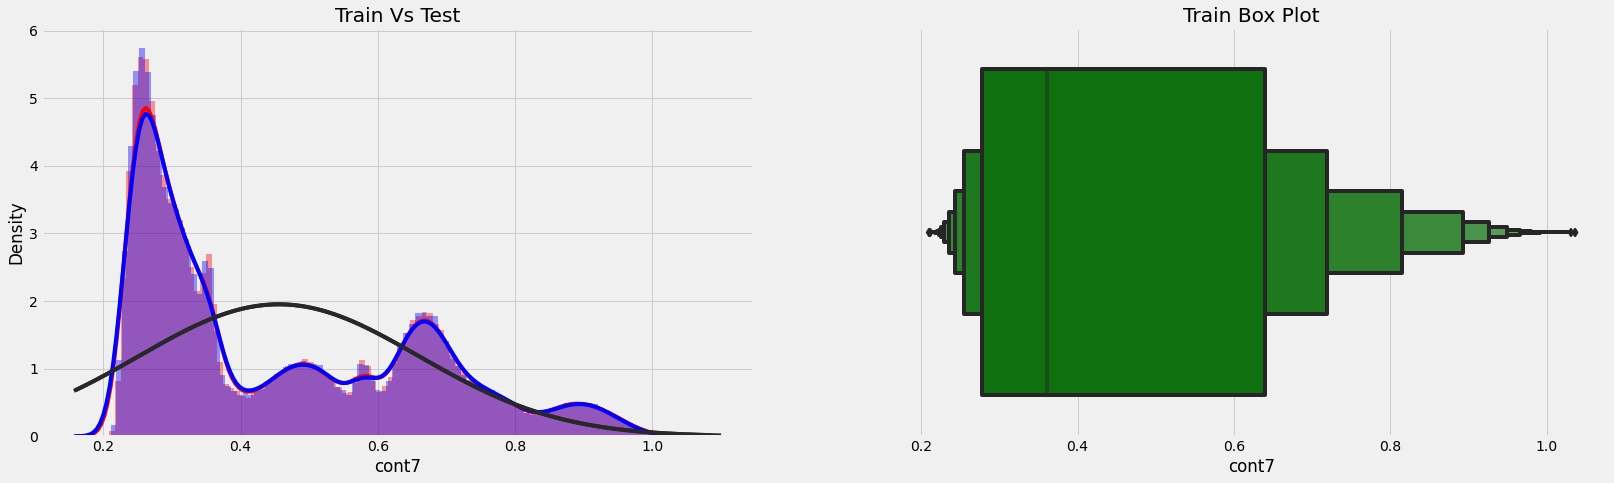

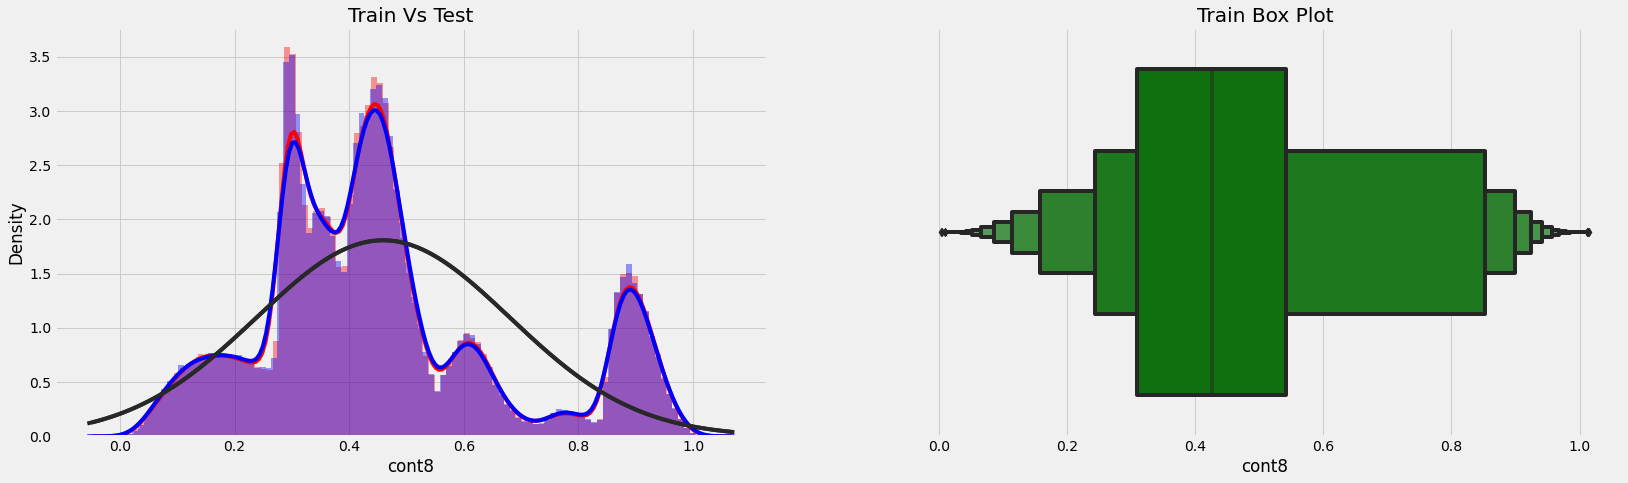

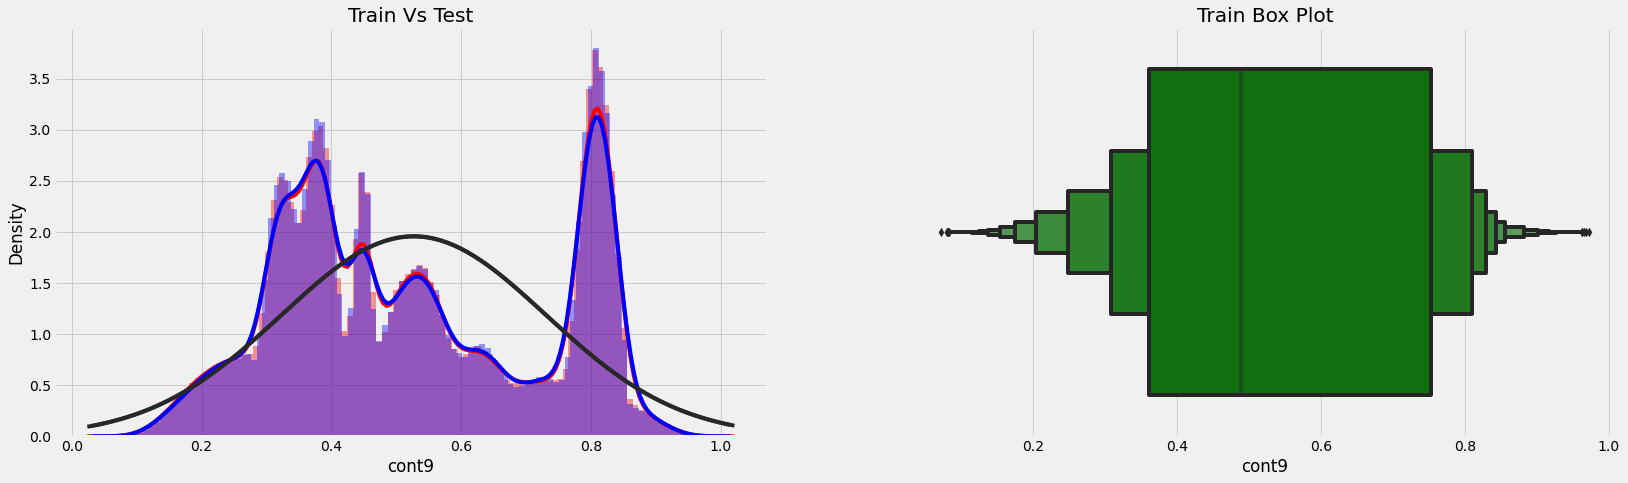

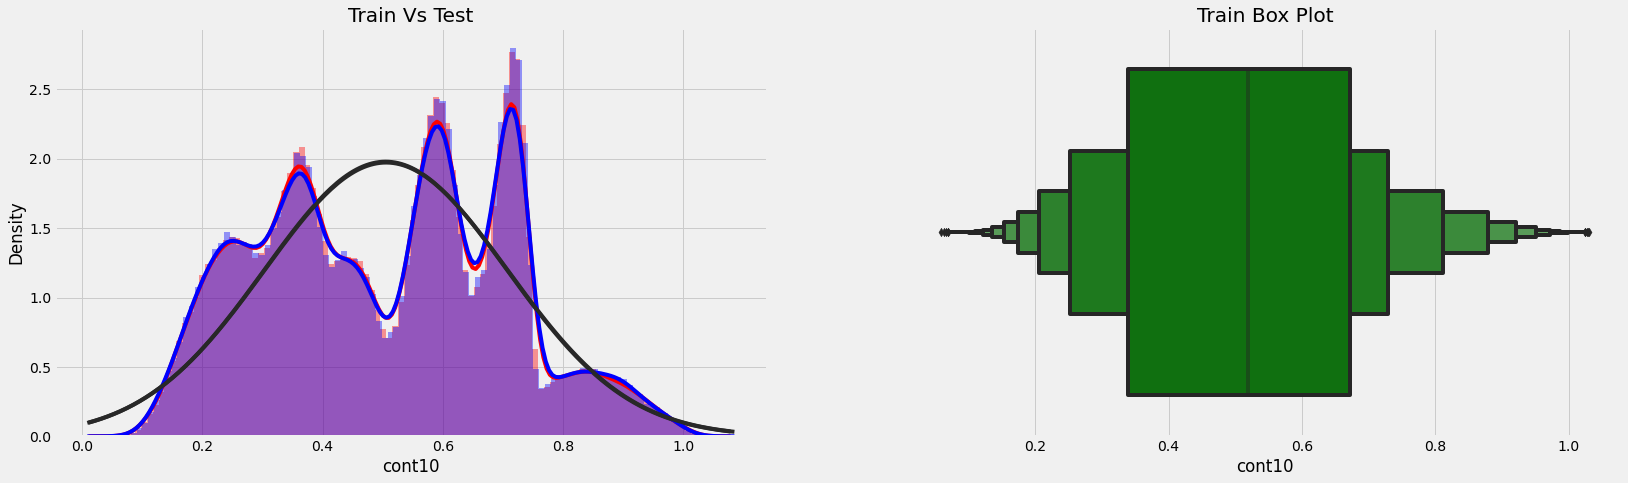

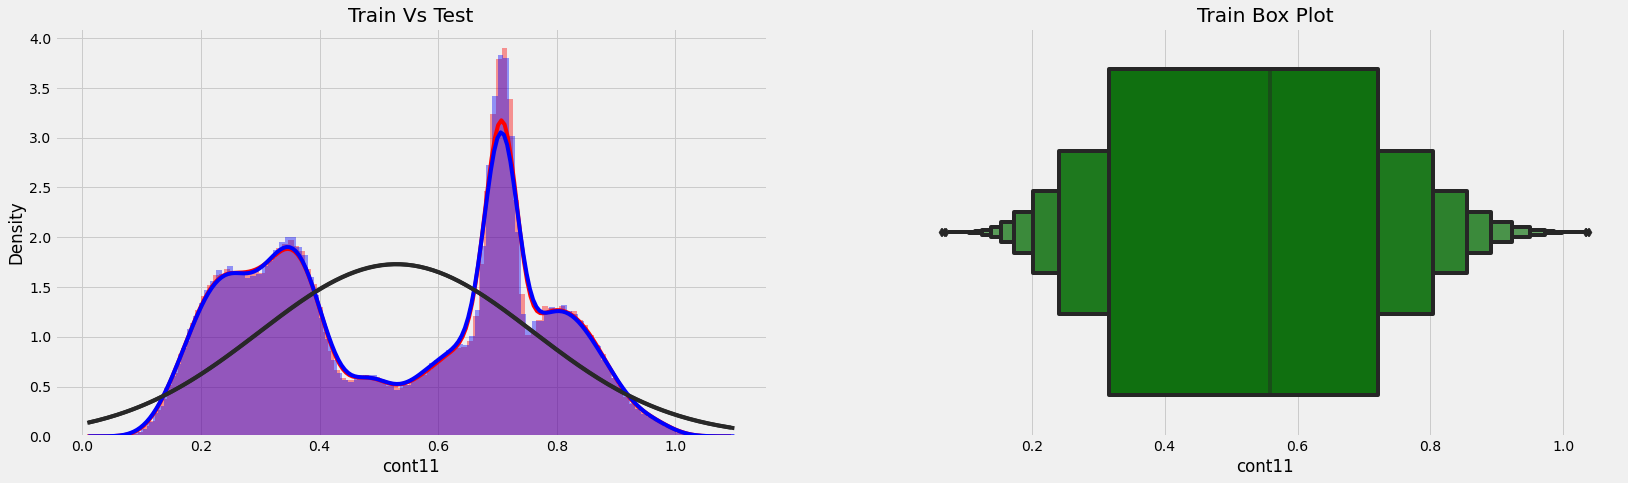

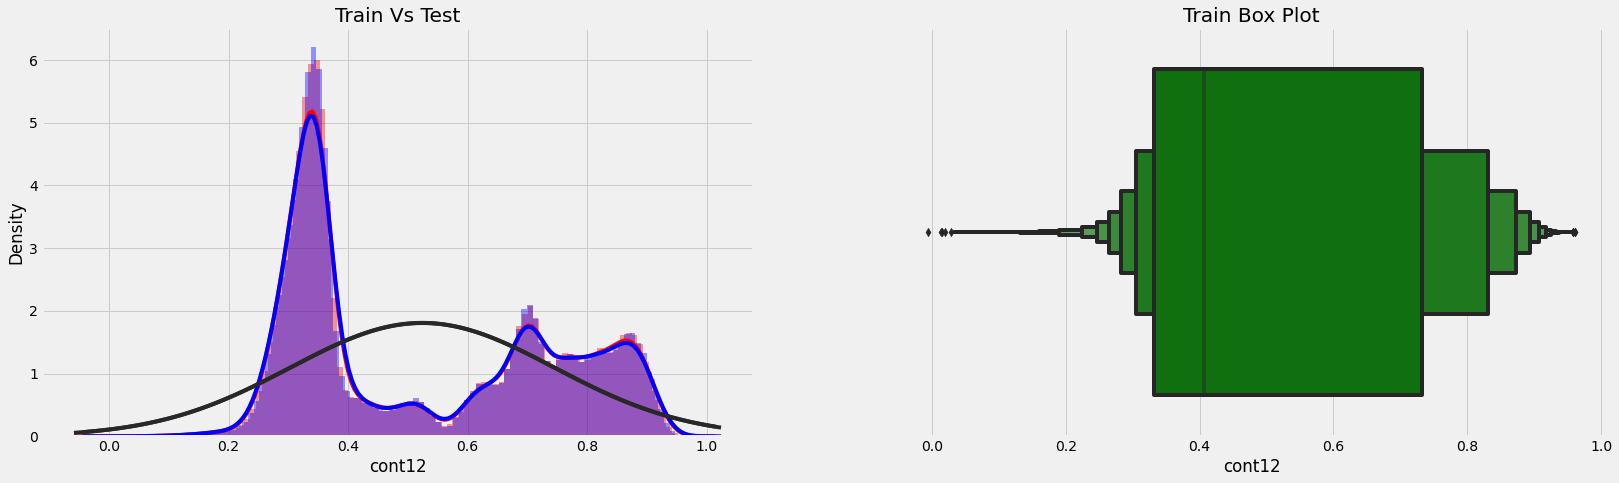

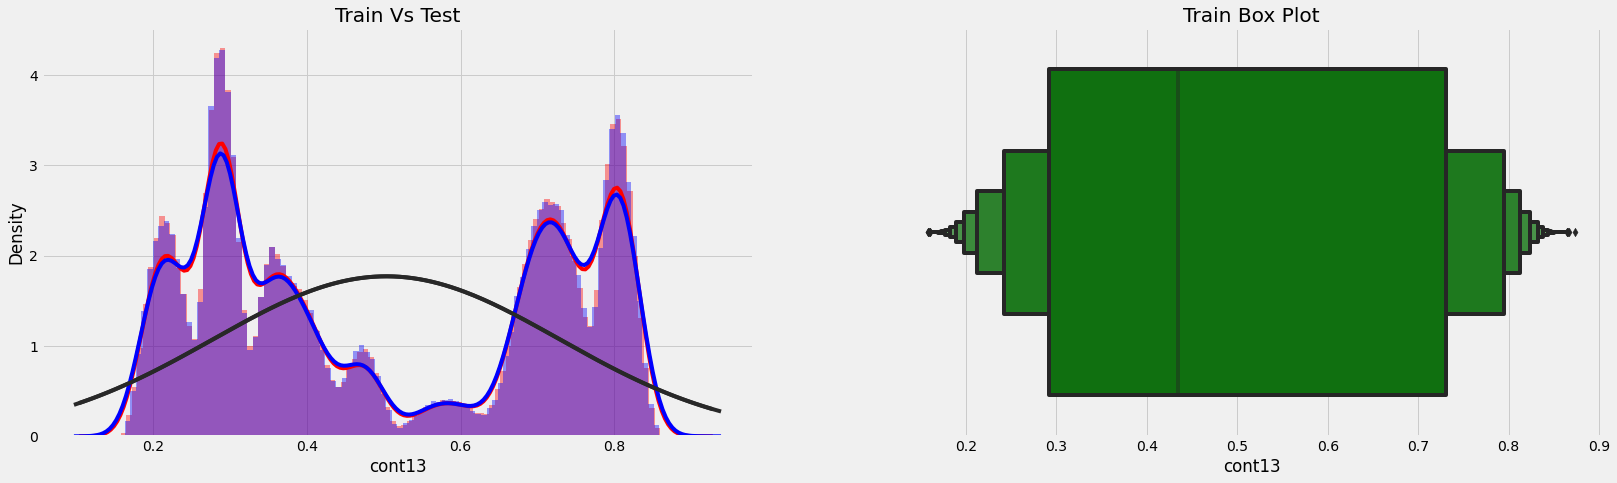

In [25]:
#trainとtestの分布を重ねて確認。 結構重い。
for c in nums:　#numsにはカテゴリでないカラムlistを。
    fig, axs = plt.subplots(ncols=2, figsize=(25, 7))
    #trainを青で描写する。
    sns.distplot(train[c],bins=100,  fit=norm, norm_hist=True,  color='red', ax=axs[0])
    #testを赤で描写する。
    sns.distplot(test[c],bins=100,  fit=norm, norm_hist=True,  color='blue', ax=axs[0])
    #重なった部分は紫になる。
    axs[0].set_title('Train Vs Test')
    
    sns.boxenplot(train[c], color='green', ax=axs[1])
    axs[1].set_title('Train Box Plot')

# ヒートマップ作成 特定の値をmask
https://qiita.com/TeRa_YUKI/items/0be0170fef0acfc36b2b

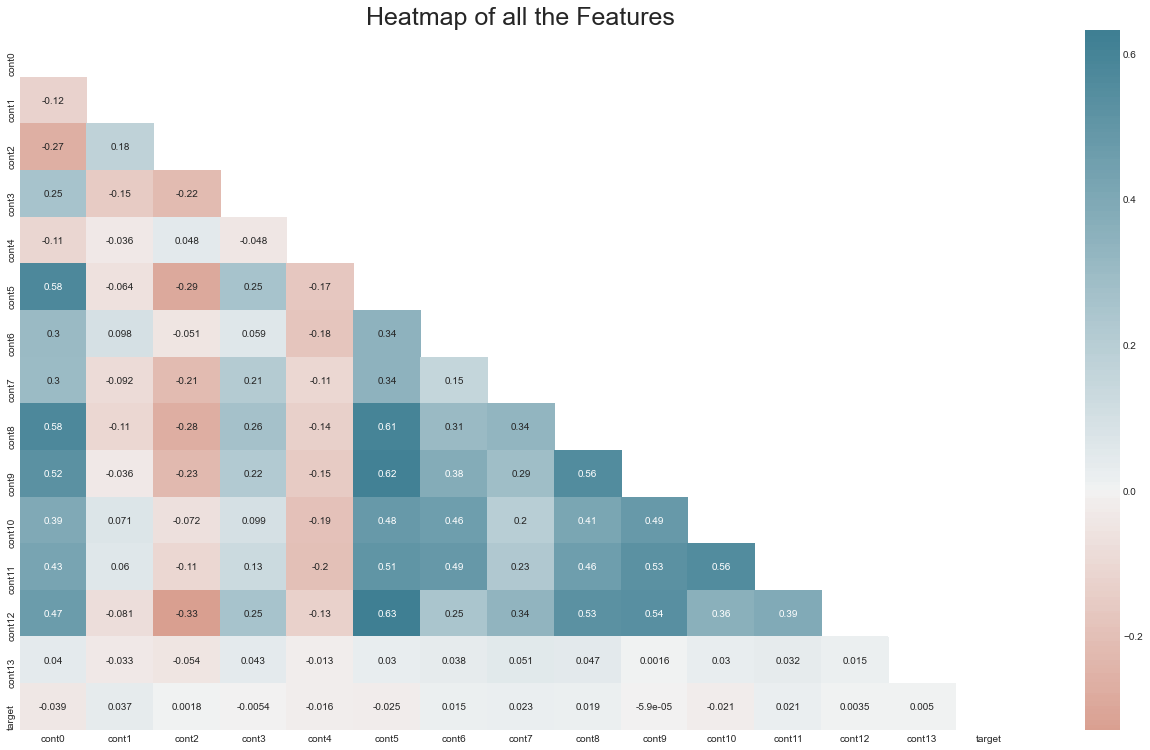

In [26]:
import matplotlib.style as style
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (20,12))

#ヒートマップ作成

# Generate a mask for the upper triangle (taken from seaborn example gallery)
#上半分の三角形を削除（マスク）
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 特定の値をマスクするならこれ。
# mask = np.zeros(train.corr(),train.corr())
# mask[np.where(heat==1)] = True       

sns.heatmap(train.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 25);

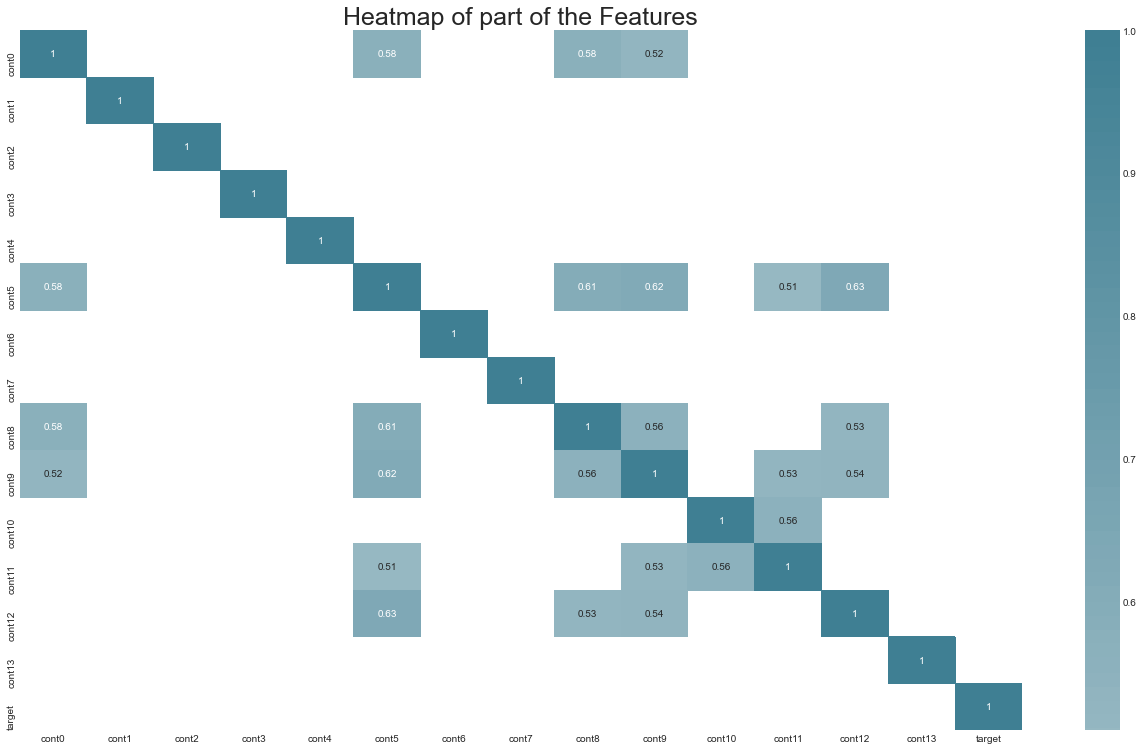

In [39]:
#ヒートマップ作成
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (20,12))
# 特定の値をマスクするならこれ。
mask = np.zeros_like(train.corr(), dtype=np.bool)
# train.corr <= n で、n以上の相関だけ表示。詳しくはnp.where
mask[np.where(train.corr() <= 0.5)] = True       

sns.heatmap(train.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
## Give title. 
plt.title("Heatmap of part of the Features", fontsize = 25);     

# カテゴリ変数の　特徴名、uniqieな値の名前、uniqueな値の個数、nanの数をdfに。

In [10]:
#カテゴリ変数の　特徴名、uniqieな値の名前、uniqueな値の個数、nanの数をdfに。
def analyse_cats(df, cat_cols):
    #からのdfを作成。この名前をdfにするとややこしい。
    d = pd.DataFrame()
    #作りたいカラムの頭文字をとって空のリストを作成。
    cl = [];u = [];s =[]; nans =[]
    for c in cat_cols:#カテゴリ変数のlist
        #空のリストに処理したものを代入。
        cl.append(c); u.append(df[c].unique());s.append(df[c].unique().size);nans.append(df[c].isnull().sum())
    #空のdfにカラム名を付けて各listを代入。
    d['"feat"'] = cl;d["uniques"] = u; d["cardinality"] = s; d["nans"] = nans
    return d

plt.style.use('fivethirtyeight')
#関数を実行。
catanadf = analyse_cats(train, cats)
catanadf

,"""feat""",uniques,cardinality,nans
0,cat0,"[A, B]",2,0
1,cat1,"[B, A]",2,0
2,cat2,"[A, B]",2,0
3,cat3,"[A, C, D, B]",4,0
4,cat4,"[B, C, A, D]",4,0
5,cat5,"[D, B, A, C]",4,0
6,cat6,"[A, B, D, C, E, I, G, H]",8,0
7,cat7,"[E, B, D, G, F, A, C, I]",8,0
8,cat8,"[C, A, G, E, D, F, B]",7,0
9,cat9,"[I, F, N, K, B, L, G, H, O, A, J, M, C, D, E]",15,0


# 1. Label Encoding

In [11]:
for c in cats:
    le = LabelEncoder()
    le.fit(list(train[c].astype(str)) + list(test[c].astype(str)))
    train[c] = le.transform(train[c].astype(str))
    test[c] = le.transform(test[c].astype(str))
    #dict = 辞書に変換
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print('target mapping :  ',c ,  le_name_mapping)

target mapping :   cat0 {'A': 0, 'B': 1}
target mapping :   cat1 {'A': 0, 'B': 1}
target mapping :   cat2 {'A': 0, 'B': 1}
target mapping :   cat3 {'A': 0, 'B': 1, 'C': 2, 'D': 3}
target mapping :   cat4 {'A': 0, 'B': 1, 'C': 2, 'D': 3}
target mapping :   cat5 {'A': 0, 'B': 1, 'C': 2, 'D': 3}
target mapping :   cat6 {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'G': 5, 'H': 6, 'I': 7}
target mapping :   cat7 {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'I': 7}
target mapping :   cat8 {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
target mapping :   cat9 {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14}


# 2. One-Hot Encoding, Dummy Encoding

In [13]:
#copyのcopyをとる。
train_copy = tr_orig.copy()
test_copy = ts_orig.copy()
#targetのcopyを作成。
target_copy = train_copy.pop('target')#２回目実行注意！
#trainとcopyを横結合。
data_copy = pd.concat([train_copy, test_copy], axis=0)
#dummy変数化。
data_copy = pd.get_dummies(data_copy)
#再度trainとtestに分割。横結合してるだけなので単純に行をサイズ順にとればいい。
train_copy = data_copy.iloc[:len(train_copy), ]
test_copy = data_copy.iloc[:len(test_copy), ]

In [16]:
ss = RobustScaler()
train_copy[nums]= ss.fit_transform(train_copy[nums])
test_copy[nums]= ss.fit_transform(test_copy[nums])

In [17]:
train_copy.shape, test_copy.shape

((300000, 70), (200000, 70))

# 3. Frequency Encoding

In [60]:
train_copy2 = tr_orig.copy()
test_copy2 = ts_orig.copy()

target_copy2 = train_copy2.pop('target')
#trainとtestを縦結合。
daset = pd.concat([train_copy2, test_copy2], axis=0)

In [61]:

for c in (cats):
    #各カラムの各ダミー変数毎に数を数えて全体の数で割ることで頻度を算出。
    #mapを使って、各カラムの各要素に、元のダミー変数の値に応じた頻度を代入。
    daset[c+'_freq'] = daset[c].map(daset.groupby(c).size() / daset.shape[0])
    #何番めの数がもともと何の値だったのかを順番に示すindexの配列。
    indexer = pd.factorize(daset[c], sort=True)[1]
    #良くわからん。なくてもいけそう。
    daset[c] = indexer.get_indexer(daset[c])

train_copy2= daset.iloc[:len(train) , ]
test_copy2= daset.iloc[len(train): , ]
cols=train_copy2.columns
train_copy2.shape, test_copy2.shape

((300000, 34), (200000, 34))

# mapの使いかた
https://qiita.com/conf8o/items/0cb02bc504b51af09099

In [62]:
#数値に変換したリストと、何番めの数がもともと何の値だったのかを示す配列を返す。
pd.factorize(daset['cat8'], sort=True)[0]

array([2, 0, 2, ..., 2, 2, 6])

In [63]:
indexer.get_indexer(daset['cat8']),daset['cat8']

(array([-1, -1, -1, ..., -1, -1, -1]),
 0         2
 1         0
 2         2
 3         6
 4         2
          ..
 199995    6
 199996    4
 199997    2
 199998    2
 199999    6
 Name: cat8, Length: 500000, dtype: int64)

# 4. Target Encoding - Mean Likelihood Encoding ,"The Right Way !"
https://qiita.com/suaaa7/items/cfe9a9e516b5b784570f
:
https://blog.amedama.jp/entry/target-encoding-and-stacking

In [80]:
train_3 = tr_orig.copy()
test_3 = ts_orig.copy()
target_3 = train_3.pop('target')

In [81]:
# target mean Encodingは、targetの情報を利用し、カテゴリカル変数を数値に変換する方法。
#目的変数がBoolean表現の場合、カテゴリごとのtargetの確率を、数値であればカテゴリごとのtargetの平均を特徴量とする。
# smoothingによってoverfitが抑えられる。
smoothing =1
#category_encodersはdfを返すから便利。
import category_encoders as ce
#空のdfを作っとく。
oof = pd.DataFrame([])
from sklearn.model_selection import KFold
#tr_idxがtrain役、off_idxがtest役。trainとtestを５分割
#KFold#split() で手に入るのは単なるインデックスなので、それを元に DataFrame から対象データを抽出しないといけない。
for tr_idx, oof_idx in KFold(n_splits=5, random_state=2020, shuffle=True).split(train_3, target_3):
    #smoothingを指定。
    ce_target_encoder = ce.TargetEncoder(cols = cats, smoothing=smoothing)
    #元のtrainに対してtr_idxのとこを、元のtargetに対してもtr_idxのとこを
    #学習用のデータと結果を学習する。（教師）
    ce_target_encoder.fit(train_3.iloc[tr_idx, :], target_3.iloc[tr_idx])
    #元のtrainに対してoff_idx(test役)のところで予測
    oof = oof.append(ce_target_encoder.transform(train_3.iloc[oof_idx, :]), ignore_index=False)
#trainとtargetでデータと結果を学習する。
ce_target_encoder = ce.TargetEncoder(cols = cats, smoothing=smoothing)
ce_target_encoder.fit(train_3, target_3);  train_3 = oof.sort_index()
#testで予測する。
test_3 = ce_target_encoder.transform(test_3)

# K-Foldの際の注意点：KFold#split() で手に入るのは単なるインデックスなので、それを元に DataFrame から対象データを抽出しないといけない。
https://blog.amedama.jp/entry/2018/06/21/235951

In [82]:
train_3.shape,test_3.shape

((300000, 24), (200000, 24))

# 5. Hash Encoding

# https://developers.microad.co.jp/entry/2018/12/07/184133

In [86]:
train_4 = tr_orig.copy()
test_4 = ts_orig.copy()

target_4 = train_4.pop('target')
data_4 = pd.concat([train_4, test_4], axis=0)

In [ ]:
#なんか警告みたいなんでる。
#Create object for hash encoder
encoder=ce.HashingEncoder(cols=cats,n_components=6)
data_4 = encoder.fit_transform(data_4)
train_4 = data_4.iloc[:len(train_4), ]
test_4 = data_4.iloc[len(train_4):, ]

In [96]:
train_4

,col_0,col_1,col_2,col_3,col_4,col_5,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,8,0,0,1,1,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903
1,1,8,0,0,1,0,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464
2,0,8,0,0,1,1,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352
3,0,7,0,0,2,1,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766
4,1,8,0,0,1,0,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0,7,0,1,2,0,0.260716,0.712438,0.161661,0.442794,0.768447,0.269578,0.258655,0.363598,0.300619,0.340516,0.235711,0.383477,0.215227,0.793630
299996,0,7,0,1,2,0,0.173302,0.121591,0.592514,0.193711,0.775951,0.197211,0.257024,0.574304,0.227035,0.322583,0.286094,0.324874,0.306933,0.230902
299997,0,8,1,0,1,0,0.342856,0.617869,0.462991,0.418098,0.297406,0.449482,0.386172,0.476217,0.135947,0.502730,0.235788,0.316671,0.250286,0.349041
299998,1,7,0,0,1,1,0.599403,0.686054,0.660860,0.187199,0.758642,0.363130,0.324132,0.229017,0.220888,0.515304,0.389391,0.245234,0.303895,0.481138


# 6. Bayesian Target Encoding and Lightgbm

# 一応Classのselfについて。
https://www.sejuku.net/blog/64106

# クラスについて
https://qiita.com/motoki1990/items/376fc1d1f3d59c960f5c

In [97]:
import gc
import numpy as np 
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

    #引数はカラム名 
class BetaEncoder(object):
       
    def __init__(self, group):
        
        self.group = group
        self.stats = None
        
    # get counts from df
    def fit(self, df, target_col):
        self.prior_mean = np.mean(df[target_col])
        stats = df[[target_col, self.group]].groupby(self.group)
        stats = stats.agg(['sum', 'count'])[target_col]    
        stats.rename(columns={'sum': 'n', 'count': 'N'}, inplace=True)
        stats.reset_index(level=0, inplace=True)           
        self.stats = stats
        
    # extract posterior statistics
    def transform(self, df, stat_type, N_min=1):
        
        df_stats = pd.merge(df[[self.group]], self.stats, how='left')
        n = df_stats['n'].copy()
        N = df_stats['N'].copy()
        
        # fill in missing
        nan_indexs = np.isnan(n)
        n[nan_indexs] = self.prior_mean
        N[nan_indexs] = 1.0
        
        # prior(事前) parameters
        N_prior = np.maximum(N_min-N, 0)
        alpha_prior = self.prior_mean*N_prior
        beta_prior = (1-self.prior_mean)*N_prior
        
        # posterior（事後） parameters
        alpha = alpha_prior + n
        beta =  beta_prior + N-n
        
        # 統計量を計算
        if stat_type=='mean':
            num = alpha
            dem = alpha+beta
                    
        elif stat_type=='mode':
            num = alpha-1
            dem = alpha+beta-2
            
        elif stat_type=='median':
            num = alpha-1/3
            dem = alpha+beta-2/3
        
        elif stat_type=='var':
            num = alpha*beta
            dem = (alpha+beta)**2*(alpha+beta+1)
                    
        elif stat_type=='skewness':#skewness=歪度
            num = 2*(beta-alpha)*np.sqrt(alpha+beta+1)
            dem = (alpha+beta+2)*np.sqrt(alpha*beta)

        elif stat_type=='kurtosis':#kurtosis=尖度
            num = 6*(alpha-beta)**2*(alpha+beta+1) - alpha*beta*(alpha+beta+2)
            dem = alpha*beta*(alpha+beta+2)*(alpha+beta+3)

        else:
            num = self.prior_mean
            dem = np.ones_like(N_prior)
            
        # replace missing
        value = num/dem
        #nanmedianはnanを無視して計算。
        value[np.isnan(value)] = np.nanmedian(value)
        return value
        



cat_cols = cats
train = tr_orig.copy()
test = ts_orig.copy()

#lgbのパラメータ設定。
lgb_params = {
    'learning_rate': 0.02,
    'application': 'regression',
    
    'num_leaves': 10,
    'verbosity': -1,
    'metric': 'rmse',
    'data_random_seed': 3,
    'bagging_fraction': 0.7,
    'feature_fraction': 0.5,
    'bagging_frequency': 1,
    'lambda_l1': 1,
    'lambda_l2': 1,
   # 'min_data_in_leaf': 40,
}

n_folds = 5
n_rounds = 400

for N_min in [10, 100, 1000, 10000, -1]: 

    print('label encoding')
    for col in cat_cols:
        le = LabelEncoder()
        le.fit(np.concatenate([train[col], test[col]]))
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
        
            
    scores = []
    cbe_lgb_pred = np.zeros(len(test))
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    for i, (dev_index, val_index) in enumerate(kf.split(train.index.values)):
        
        print(f'Fold {i}:')
        
        # split data
        dev = train.loc[dev_index].reset_index(drop=True)
        val = train.loc[val_index].reset_index(drop=True)
    
        # built-in categorical encoding
        if N_min==-1: 
            
            feature_cols = cat_cols
            
            # setup lightgbm data
            d_dev = lgb.Dataset(dev[cat_cols],
                                label=dev.target,
                                feature_name=cat_cols,
                                categorical_feature=cat_cols)
            d_val = lgb.Dataset(val[cat_cols],
                                label=val.target,
                                feature_name=cat_cols,
                                categorical_feature=cat_cols)
    
        # target encoding
        else: 
            
            # encode variables
            feature_cols = []
            for var_name in cat_cols:
        
                # fit encoder
                #ここで作ったBetaEncoderを使う。引数はカラム名。
                be = BetaEncoder(var_name)
                be.fit(dev, 'target')
        
                # mean
                feature_name = f'{var_name}_mean'
                dev[feature_name]  = be.transform(dev,  'mean', N_min)
                val[feature_name]  = be.transform(val,  'mean', N_min)
                test[feature_name] = be.transform(test, 'mean', N_min)        
                feature_cols.append(feature_name)
                
            # setup lightgbm data
            d_dev = lgb.Dataset(dev[feature_cols], label=dev.target)
            d_val = lgb.Dataset(val[feature_cols], label=val.target)
        
        # fit model
        mdl = lgb.train(lgb_params,
                          train_set = d_dev,
                          num_boost_round = n_rounds,
                          valid_sets = [d_dev, d_val],
                          verbose_eval = n_rounds//5)
        scores.append(mdl.best_score['valid_1']['rmse'])
        
        # make predictions on test set
        cbe_lgb_pred += mdl.predict(test[feature_cols])/n_folds    
        
    # clean up
    del d_dev, d_val, mdl
    gc.collect()
    
    # print results
    if N_min==-1:
        print(f'baseline: {np.mean(scores):0.2f}')
    else: 
        print(f'N_min={N_min}: {np.mean(scores):0.2f}')
        
    # save data
    #subm['deal_probability'] = np.clip(subm['deal_probability'], 0, 1)
    #if N_min==-1:
    #    subm.to_csv(f'submission-baseline.csv', index=False)
    #else: 
    #    subm.to_csv(f'submission-{N_min}.csv', index=False)

label encoding
Fold 0:
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[80]	training's rmse: 0.872075	valid_1's rmse: 0.871441
[160]	training's rmse: 0.869163	valid_1's rmse: 0.868857
[240]	training's rmse: 0.868475	valid_1's rmse: 0.868369
[320]	training's rmse: 0.868233	valid_1's rmse: 0.868262
[400]	training's rmse: 0.868099	valid_1's rmse: 0.868236
Fold 1:
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[80]	training's rmse: 0.87238	valid_1's rmse: 0.870527
[160]	training's rmse: 0.869526	valid_1's rmse: 0.8677
[240]	training's rmse: 0.868866	valid_1's rmse: 0.867066
[320]	training's rmse: 0.868632	valid_1's rmse: 0.866883
[400]	training's rmse: 0.868501	valid_1's rmse: 0.866819
Fold 2:
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[80]	training's rmse: 0.871626	valid_1's rmse: 0.873253
[160]	training's rmse: 0.868701	valid_1's rmse: 0.870694
[240]	training's rmse: 0.86801	valid_1's rmse: 0.870265
[320]	training's rmse: 0.867768	valid_1's rmse: 0.870

# 7. CatBoost and Cats

In [98]:
train = tr_orig.copy()
test = ts_orig.copy()

target = train.pop('target')
categorical_features_indices = np.where(train.dtypes == 'object')[0]
categorical_features_indices

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [99]:
cat_score = []
# Split data with kfold
kfolds = KFold(n_splits=3, shuffle=True, random_state=2018)
train_features = train.columns
# Make importance dataframe
importances = pd.DataFrame()

oof_preds = np.zeros(train.shape[0])
sub_preds = np.zeros(test.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(kfolds.split(train, target)):
    X_train, y_train = train.iloc[trn_idx], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx], target.iloc[val_idx]
    
    # CatBoost Regressor estimator
    # CatBoost　回帰　識別器
    model = cb.CatBoostRegressor(
        learning_rate = 0.1,
        iterations = 2000,
        eval_metric = 'RMSE',
        allow_writing_files = False,
        od_type = 'Iter',
        bagging_temperature = 0.8,
        depth = 6,
        od_wait = 20,
        silent = False
    )
    
    # データと結果を学習（教師）
    model.fit(
        X_train, y_train,
        cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=100,
        early_stopping_rounds=100
    )
    
    # Feature import
    #重要特徴量を取得。
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = model.get_feature_importance()
    imp_df['fold'] = n_fold + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_idx] = model.predict(X_valid)
    cat_score.append(np.sqrt(mean_squared_error(y_valid, oof_preds[val_idx])))
    test_preds = model.predict(test)
    sub_preds += test_preds / kfolds.n_splits
    
print(np.mean(cat_score))

0:	learn: 0.8849881	test: 0.8849881	test1: 0.8823874	best: 0.8823874 (0)	total: 1.05s	remaining: 35m 8s
100:	learn: 0.8486356	test: 0.8484235	test1: 0.8498500	best: 0.8498500 (100)	total: 1m 9s	remaining: 21m 47s
200:	learn: 0.8419633	test: 0.8418186	test1: 0.8462056	best: 0.8462056 (200)	total: 2m 12s	remaining: 19m 42s
300:	learn: 0.8375538	test: 0.8375146	test1: 0.8448569	best: 0.8448569 (300)	total: 3m 14s	remaining: 18m 18s
400:	learn: 0.8342065	test: 0.8342950	test1: 0.8441735	best: 0.8441735 (400)	total: 4m 24s	remaining: 17m 35s
500:	learn: 0.8311418	test: 0.8313577	test1: 0.8438535	best: 0.8438528 (497)	total: 5m 33s	remaining: 16m 36s
600:	learn: 0.8284913	test: 0.8288935	test1: 0.8436665	best: 0.8436654 (599)	total: 6m 30s	remaining: 15m 9s
700:	learn: 0.8260389	test: 0.8266166	test1: 0.8436769	best: 0.8436369 (630)	total: 7m 46s	remaining: 14m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8436368725
bestIteration = 630

Shrink model to first 631 i

<AxesSubplot:xlabel='gain_log', ylabel='feature'>

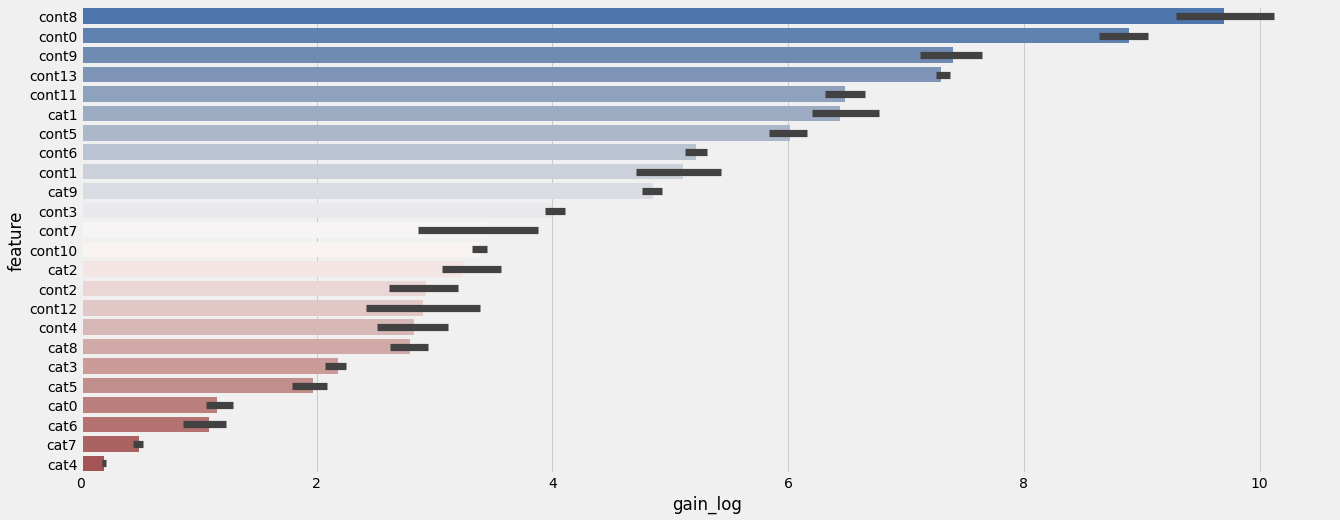

In [100]:
importances['gain_log'] = importances['gain']
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(20, 8))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False), palette='vlag')

# 8. LightGBM and Cats

In [ ]:
train = tr_orig.copy()
test = ts_orig.copy()

target = train.pop('target')

In [ ]:
for c in cats:
    le=LabelEncoder()
    le.fit(list(train[c].astype('str')) + list(test[c].astype('str')))
    train[c] = le.transform(list(train[c].astype(str))) 
    test[c] = le.transform(list(test[c].astype(str))) 
train.head()

In [ ]:
lgb_params = {
    
 'objective': 'rmse', 
 'boosting': 'gbdt', 
 'bagging_fraction': 0.7,
 'bagging_frequency': 1,
 'cat_smooth': 200,
 'feature_fraction': 0.7,
 'learning_rate': 0.01,
 'min_child_samples': 50,
 'min_data_per_group': 200,
 'num_leaves': 10,
 'reg_alpha': 2.,
 'reg_lambda': 3., 
 'metric':'rmse', 
 }
    
    
    
    


oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))

scores = []

feature_importances_gain = pd.DataFrame()
feature_importances_gain['feature'] = train.columns

feature_importances_split = pd.DataFrame()
feature_importances_split['feature'] = train.columns


folds = KFold(n_splits=3, shuffle=True, random_state=42)

for fold_, (train_ind, val_ind) in enumerate(folds.split(train, target)):
    print("fold : ---------------------------------------", fold_)
    trn_data = lgb.Dataset(train.iloc[train_ind], label=target.iloc[train_ind], categorical_feature=cats) #-------> Specify Categorical feature for lgb
    val_data= lgb.Dataset(train.iloc[val_ind], label=target.iloc[val_ind], categorical_feature=cats)  #-------> Specify Categorical feature for lgb
    
    lgb_clf = lgb.train(lgb_params, trn_data, num_boost_round=3000, valid_sets=(trn_data, val_data), verbose_eval=100, early_stopping_rounds=100)
    oof_lgb[val_ind] = lgb_clf.predict(train.iloc[val_ind], num_iteration= lgb_clf.best_iteration)
    
    scores.append(np.sqrt(mean_squared_error(target.iloc[val_ind], oof_lgb[val_ind])))
    
    feature_importances_gain['fold_{}'.format(fold_ + 1)] = lgb_clf.feature_importance(importance_type='gain')
    feature_importances_split['fold_{}'.format(fold_ + 1)] = lgb_clf.feature_importance(importance_type='split')
    
    pred_lgb += lgb_clf.predict(test, num_iteration=lgb_clf.best_iteration)/folds.n_splits
    
print(np.mean(scores))
    

In [ ]:
feature_importances_gain['average'] = feature_importances_gain[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances_gain.to_csv('feature_importances.csv')

plt.figure(figsize=(20, 8))
sns.barplot(data=feature_importances_gain.sort_values(by='average', ascending=False).head(100),palette='Reds_r',  x='average', y='feature');
plt.title('TOP n feature importance over {} folds average'.format(folds.n_splits));